# Homework 5: Dimension Reduction, Clustering, and the MNIST Dataset


![NumbersUrl](https://media.giphy.com/media/l0MYFdyFmEmGQ3Zvy/giphy.gif "Numbers")

In this assignment we will be using the MNIST dataset (see below to learn more) in order to practice Dimension Reduction and Clustering methods.

> The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. ...The MNIST data set is hand-drawn digits, from zero through nine. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive. - Wikipedia

To start off, we need to import our basic modules:

In [1]:
#import our basic data manipulation modules
import pandas as pd
import numpy as np
import scipy

#import our basic visualization modules
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#turn off warnings for sns depreciated versions- this is the best
import warnings
warnings.filterwarnings('ignore')

#import modules that contains our dataset
from sklearn.datasets import fetch_mldata

#import decomposition
from sklearn.decomposition import PCA

As explained in the Assignment, we will be using the `fetch_mldata` function in order to load the data. However, it is being depreciated currently so we expect to see an error below as we import the data using this method.

In [38]:
#import data from the dataset and call it mnist
mnist = fetch_mldata("MNIST original")

C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\zgeorge\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


Now that we've imported our data, the next step is the scale the data and preserve the target variable so that we can use them in the future.

In [3]:
#Scaling the MNIST data
X = mnist.data / 255.0
#Retain target as a new variable
y = mnist.target

Now that we have our data prepared, we can use our first method of dimension reduction, PCA.

## Using PCA to reduce the dimensionality of a dataset (1)



### Why would you use PCA? What is it doing? And what are the drawbacks? (1.c)

Principal component analysis (PCA) is a technique used to emphasize variation and bring out strong patterns in a dataset. It's often used to make data easy to explore and visualize. It is used to decrease dimensionality, reduce the overfitting, and allows us to pick up as much variation as possible in as few dimensions as possible. This is accomplished by finding a line that collects the most variation possible as a primary component and axis, then the following components are set orthagnally to the primary component.

The primary issue lies within the fact that after PCA is done it combines the dimensions into complements and then we can choose what to include or exclude in a model you are building. However, you cant identify the exact attributes/dimensions feed into in the component from the output, which makes it inherently less useful.

### How many components did you use? Why? (1.a)
There are two ways of determining the number of components necessary to achieve the level of variance required:

- We can use the elbow method, where we visually measure at what point the amount of variance per new component added begins to decrease rapidly (at the elbow of the curve)

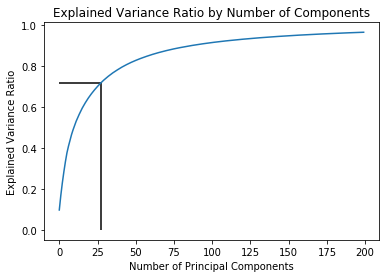

Explained Variance Ratio: 0.7173295431692414
Number of Components Used: 27


In [39]:
#Perform a PCA with 200 components
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X)
#Determine the cumulative explained variance ratio (percentage of variance retained)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
#plot the curve of variance retained
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[27],x=27)
#mark the intersection that we are interested in
plt.hlines(cum_ratio[27],0,27)
#Properly explain the plot
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.title('Explained Variance Ratio by Number of Components')
plt.show()
#Explain your results
print("Explained Variance Ratio: {}".format(cum_ratio[27]))
print("Number of Components Used: {}".format(27))

Unfortunately, this method only gives us approximately 70% of the variance in the data, which if we want to be effective, is not enough. Lets move on to the next option!

- The other option is to focus more specifically on the amount of total variance retained. This is the method that we will be using for this project. We want to retain 95% of the variance in our data. Let's see how many components that will require:

In [5]:
#Use PCA with an output that will retain 95% of our variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
n,components = X_pca.shape
#Explain the output of the PCA Transformation
print("{} components will be used to retain 95% of the variance.".format(components))

154 components will be used to retain 95% of the variance.


It appears that we will be using 154 components because it retains 95% of the variance in the data. That will work well and we still removed more than 200 dimensions! Now lets see what that looks like visually.

### Plotting the first two components (1.b.1)
In order to see what this looks like, lets create a plot of the first two components that we retrevied from the PCA transformation. Remember this is going to reduce 784 components down to just two, so we shouldn't be surprised if we don't recognize it.


Text(0.5, 1.0, 'First Two Components via PCA')

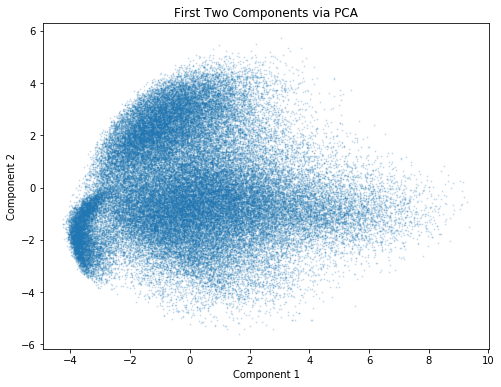

In [6]:
#Create our scatter plot from the first two components
fig = plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],alpha=.19,marker=".",s=3)
#Appropriately label and title the plot
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('First Two Components via PCA', )

#### Do you notice any trends? What is this plot showing us? (1.b.2)
This plot shows the first two components of the PCA output, the first having the highest variance and the second being an orthagonal axis. This allows us to see the most amount of variance possible, however it also means that we won't be able to see any trends or patterns in a recognizable form. This doesn't really help explain what the effect of PCA is, but it does explain what the problem is with using it, meaning we don't really know what is being explained by this plot. So now, lets try something that may explain PCA in a more effective manner....

### Plotting images with PCA Outputs (1.d)

#### Preparing to plot our images 
Before being able to plot our images, we will set up a couple of functions so that we don't have to reuse so much code! I was luckily able to get some help from the Matplotlib image tutorial found at the link below.

https://matplotlib.org/users/image_tutorial.html

In [7]:
#Function that allows us to plot 4 original images
def plot_digits(data):
    #Create figure that we will lay our images on
    blank,shape = data.shape
    sqr = np.sqrt(shape)
    sqshape = int(sqr)
    fig, axes = plt.subplots(2, 2, figsize=(5,5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    #Displaying images that are far apart from each other so we get a good feel for them
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[(9000*i+1500*i)].reshape((28, 28)),
                  cmap='coolwarm', interpolation='nearest',
                  clim=(0, 16))

In [8]:
#Function that will apply PCA to our data then bring it back out and tell us the effect
def pca_me_captain(n, data, listname):
    #Apply PCA
    pca = PCA(n_components= n)
    pca_data = pca.fit_transform(data)
    #inverse transform so we can see the effect
    pcai_data = pca.inverse_transform(pca_data)
    listname.append(pcai_data)
    #tell us the amount of components and variance precerved
    print("Number of Components Used: {}".format(pca.n_components_))
    print("Percent of Variance Preserved: {}%".format(pca.n_components * 100))
    listname = listname[0]

In [9]:
#Combine the two functions above
def show_me_pca(n,data):
    #Get data from pca_me_captain
    x = []
    pca_me_captain(n,data,x)
    #Plot reduced dimension data
    plot_digits(x[0])

#### Plotting MNIST Data (1.d.1)
Okay, we are now ready to see our numbers and what happens to them when we reduce their dimensionality! Lets look at the original images first.

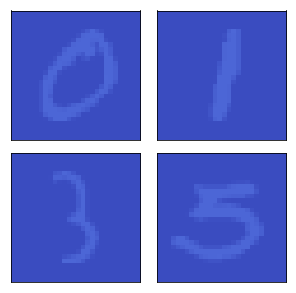

In [10]:
#Plot four original images
plot_digits(X)

Those look fantastic. Maybe a little fuzzy, but remember that we already scaled them! 
#### Plotting PCA Outputs (1.d.2)
Now lets compare that to different levels of PCA output. We'll use 10% (the first two components like we saw above), the 72% that we got from the elbow method, and the 95% that we feel would be best. Then we can compare that to the original.

Number of Components Used: 2
Percent of Variance Preserved: 10.0%


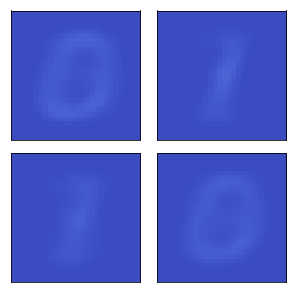

In [11]:
#Plot a 10% of variance level image
show_me_pca(.1,X)

Isn't that crazy? We can barely tell the 0 from the 5 and I wouldn't know what the 3 was! Let's try again!

Number of Components Used: 28
Percent of Variance Preserved: 71.73295431692414%


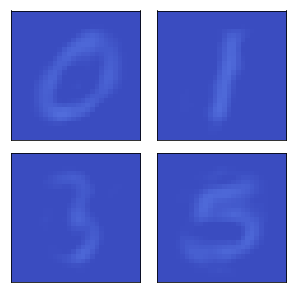

In [40]:
#plot according to the elbow method
show_me_pca(0.7173295431692414,X)

While that is pretty good, everything is pretty fuzzy, and I imagine there are other numbers that are still indistinguishable from each other! So lets try our trusty 95%.

Number of Components Used: 154
Percent of Variance Preserved: 95.0%


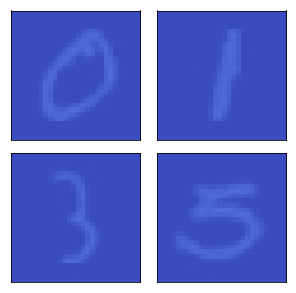

In [13]:
#Plot with 95% of variance
show_me_pca(.95,X)

#### How does it look? (1.d.3)
At 95% we can definitely feel confident that we will know what each digit is. Even from the 72% option, we see a significant increase in clarity which is definitely worth the extra dimensions.

Now PCA is not our only options. Lets look at another way of decreasing our dimensionality, and by far a more intuitive approach to plotting the data...

## Using t-SNE to plot the MNIST Data (2)
> T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton.[1] It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. - Wikipedia Entry for t-distributed Stochastic Neighbor Embedding

t-SNE is an innovative approach to reducing dimensionality and plotting data. We will need to prepare to use this function as we will be using it multiple times in a row. 


In [14]:
#Import t-SNE
from sklearn.manifold import TSNE

In [15]:
def t_SNEeze(title, p1, i1, l1):
    #use pca to reduce components
    pca = PCA(n_components=153)
    X_pca = pca.fit_transform(X)

    # Sample 10,000 rows
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    #Run and collect t-SNE for results 1
    tsne1 = TSNE(n_components=2, verbose=0, perplexity=p1, n_iter=i1, learning_rate=l1)
    tsne_results1 = tsne1.fit_transform(X_pca[rows[:n_select],:])
    df_tsne1 = pd.DataFrame(tsne_results1, columns=['First Component', 'Second Component'])
    df_tsne1['label'] = y[rows[:n_select]]
    
    #plot our data
    plt.figure(figsize=[5,5])
    fig = sns.scatterplot(x=df_tsne1['First Component'], y=df_tsne1['Second Component'], hue=df_tsne1['label'], palette=sns.color_palette("hls", 10))
    plt.title(title, fontsize=15)
    plt.show()

In [16]:
def t_SNEeze_comp(title, focus, p1, i1, l1, p2, i2, l2, p3, i3, l3):
    #use pca to reduce components
    pca = PCA(n_components=153)
    X_pca = pca.fit_transform(X)
    #create plot
    fig, ax = plt.subplots(1, 3,figsize=(18,5))
    #set up title if/thens
    if focus == "Perplexity":
        check1 = p1
        check2 = p2
        check3 = p3
    elif focus == "Learning Rate":
        check1 = l1
        check2 = l2
        check3 = l3
    else:
        check1 = i1
        check2 = i2
        check3 = i3

    # Sample 10,000 rows for results 1
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000

    #Run and collect t-SNE for results 1
    tsne1 = TSNE(n_components=2, verbose=0, perplexity=p1, n_iter=i1, learning_rate=l1)
    tsne_results1 = tsne1.fit_transform(X_pca[rows[:n_select],:])
    df_tsne1 = pd.DataFrame(tsne_results1, columns=['First Component', 'Second Component'])
    df_tsne1['label'] = y[rows[:n_select]]
    
    # Sample 10,000 rows for results 2
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000
    
    #Run and collect t-SNE for results 2
    tsne2 = TSNE(n_components=2, verbose=0, perplexity=p2, n_iter=i2, learning_rate=l2)
    tsne_results2 = tsne2.fit_transform(X_pca[rows[:n_select],:])
    df_tsne2 = pd.DataFrame(tsne_results2, columns=['First Component', 'Second Component'])
    df_tsne2['label'] = y[rows[:n_select]]
    
    # Sample 10,000 rows for results 3
    rows = np.arange(70000)
    np.random.shuffle(rows)
    n_select = 10000
    
    #Run and collect t-SNE for results 3
    tsne3 = TSNE(n_components=2, verbose=0, perplexity=p3, n_iter=i3, learning_rate=l3)
    tsne_results3 = tsne3.fit_transform(X_pca[rows[:n_select],:])
    df_tsne3 = pd.DataFrame(tsne_results3, columns=['First Component', 'Second Component'])
    df_tsne3['label'] = y[rows[:n_select]]
    
    #plot our scatterplots for each result and then title them with their specific changes
    sns.scatterplot(x=df_tsne1['First Component'], y=df_tsne1['Second Component'], hue=df_tsne1['label'], palette=sns.color_palette("hls", 10),ax=ax[0])
    ax[0].set_title( 'With a {} of {}'.format(focus, check1))
    
    sns.scatterplot(x=df_tsne2['First Component'], y=df_tsne2['Second Component'], hue=df_tsne2['label'], palette=sns.color_palette("hls", 10),ax=ax[1])
    ax[1].set_title( 'With a {} of {}'.format(focus, check2))
    
    sns.scatterplot(x=df_tsne3['First Component'], y=df_tsne3['Second Component'], hue=df_tsne3['label'], palette=sns.color_palette("hls", 10),ax=ax[2])
    ax[2].set_title( 'With a {} of {}'.format(focus, check3))
    

    # Add your title show yo' plot
    fig.suptitle(title, fontsize=18)
    plt.show()

Now that we're ready, let's consider the question....
### How does this plot differ from our PCA plot? (2.a)

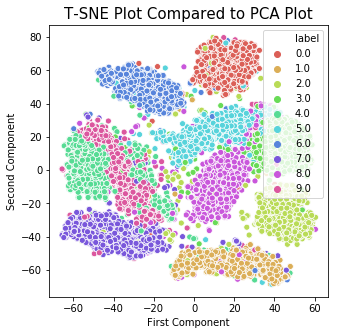

In [17]:
t_SNEeze("T-SNE Plot Compared to PCA Plot",45,1000,200)

PCA showed us how the data was plotted along the two components that introduced the most amount of variance possible. However, the t-SNE plot uses clusters to explain the areas that are either globally or locally related, based on the hyperparameter of perplexity selected. Because of this and the use of labels, we are able to determine what the computer is having difficulty. For example we can see that 4 and 9 are intermingled thoroughly (see the area around -30,0). This is something that we cannot do in PCA.

If perplexity plays such a large role in t-SNE's efficacy, let's look at how robust t-SNE is to changes in perplexity...
### How robust is it to changes in perplexity? (2.b)
We are going to compare changes in perplexity by using our origninal perplexity (middle), a decreased perplexity (left) and increased perplexity (right).

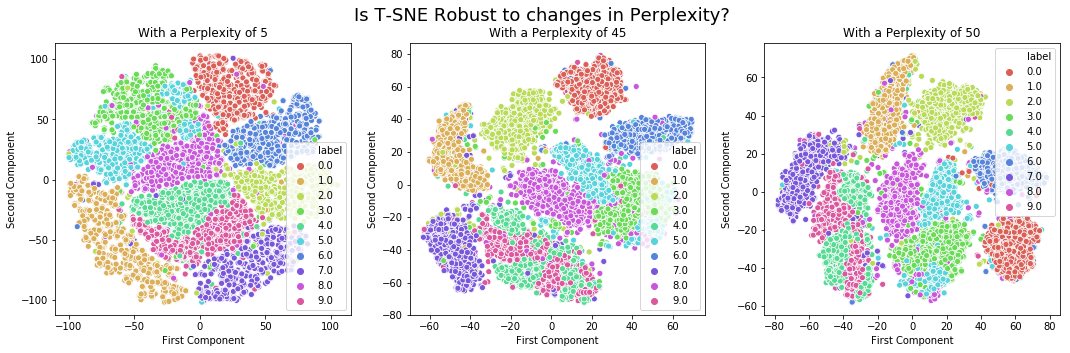

In [18]:
#Perform 3 t-SNEs and plot, with increased and decreased perplexity 
t_SNEeze_comp("Is T-SNE Robust to changes in Perplexity?","Perplexity",5,1000,200,45,1000,200,50,1000,200)

The cluster is clearly not robust to changes in perplexity. The shapes both changed and also were intermingled with different sets of numbers, depending on the level of perplexity. For example, there is a lot of 5's and 3's mixed together at perplexity=5 whereas 4 seems to be higly mixed with 9's with a perplexity of 50. 
### How robust is it to different learning rate and number of iterations? (2.c)

At this point, we recognize that perplexity heavily effects the plot. What about our other hyperparameters? Just like we did for perplexity we are going to look at both higher and lower options for both Learning Rate and number of iterations so that we can how robust the clustering is in the face of these hyperparameters.

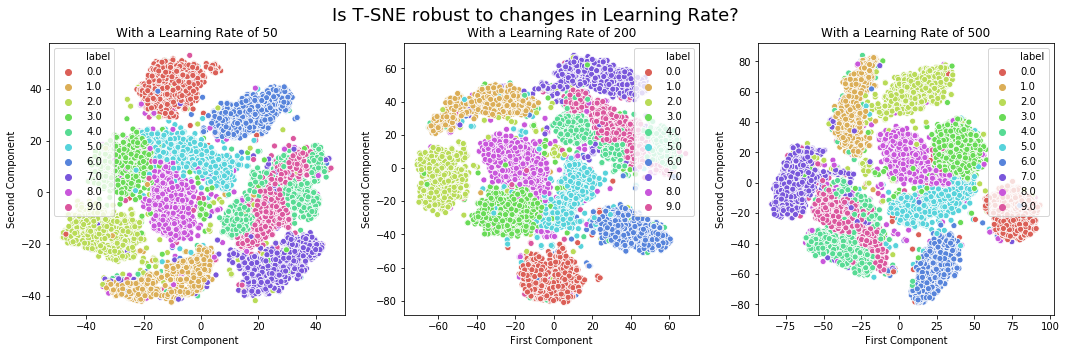

In [41]:
#Perform 3 t-SNEs and plot, with increased and decreased Learning Rate 
t_SNEeze_comp("Is T-SNE robust to changes in Learning Rate?","Learning Rate",45,1000,50,45,1000,200,45,1000,500)

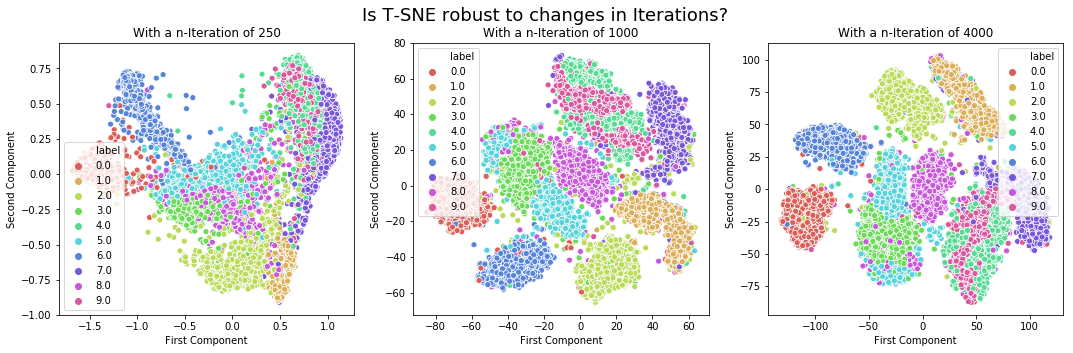

In [20]:
#Perform 3 t-SNEs and plot, with increased and decreased number of iterations
t_SNEeze_comp("Is T-SNE robust to changes in Iterations?","n-Iteration",45,250,200,45,1000,200,45,4000,200)

Again we see that the number of iterations & learning rate also heavily affect our plot. What can we learn from this? That each of the hyper parameter are very important to getting the correct clusters. That makes it very helpful to have some labeled data to start with so that we can know what to expect from our plot as we modify our hyperparameters. 

## Performing k-means clustering (3)
K-Means clustering is very helpful in determining how many groups you have in your data. We can also adjust hyperparameters in order to make it more effective if we have labeled data to start with. Let's take a test drive with this module, so first we need to import the necessary models and prepare the data

In [21]:
#import necessary data
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.utils import shuffle

In [22]:
#Shuffle and select only 10,000 rows
X_shuffled = shuffle(X)[0:10000]
#Scale our data, even though we started by scaling it down
X_scaled = preprocessing.scale(X_shuffled)

Now that our data has been prepared we need to select the most important hyperparameter for the function...
#### How do we choose k? (3.a)
With our preknowledge of the data sete, we can confidently say that our k should equal 10 as there are digits between 0-9. Therefore, we will use 10 when using K-Means Clustering.

In [23]:
#run kmeans with 10 clusters, 250 iterations at full speed on our scaled data
kmeans = KMeans(n_clusters=10, n_init=250, n_jobs=-1)
kmeans.fit(X_scaled)
#Retrieve labels
labels = kmeans.labels_

Great! we have officially used K-means clustering and retrieved our labels, but we have no idea how we did... 
#### How do we evaluate the clustering performed? (3.b)
According to SciKitLearn, http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation, there are several methods of evaluating the clustering, but `Silhouette_score` seems to have a cult following.
>When no ground truth is known, a metric like the Silhouette Coefficient can be useful. This coefficient is the mean distance between a sample and all other points in the next nearest cluste subtracted by the mean distance between a sample and all other points in the same class. The score is better when higher and ranges from -1 to 1. A higher score means the clusters are dense and well seperated. - Tyler Folkman

So lets try it!

In [24]:
#import module
from sklearn.metrics import silhouette_score

In [25]:
#Evaluate our cluster
silhouette_score(X_scaled, labels, metric='euclidean')

0.007526459874623037

Ouch. Even though the score goes between -1 and 1, that is not great. Maybe if we visualize the data we will see that we were more effective than it appears?
### Visualizing the results of our Clustering Model with t-SNE (3.c)
Lets try running the data through k-means and then display the results using t-SNE.

In [26]:
#Randomly select 10,000 data points
rows = np.arange(10000)
np.random.shuffle(rows)
n_select = 10000

In [42]:
#Create a function that does t-SNE on our kmeans results
def see_the_clusters(title,perp,n_iter,rate):
    #Run t-SNE
    tsne = TSNE(n_components=2, verbose=0, perplexity=perp, n_iter=n_iter, learning_rate=rate)
    tsne_results = tsne.fit_transform(X_scaled[rows[:n_select],:])
    #Save data and import kmeans labels
    df_tsne = pd.DataFrame(tsne_results, columns=['First Component', 'Second Component'])
    df_tsne['label'] = labels[rows[:n_select]]
    #plot
    plt.figure(figsize=[5,5])
    fig = sns.scatterplot(x=df_tsne['First Component'], y=df_tsne['Second Component'], hue=df_tsne['label'], palette=sns.color_palette("hls", 10))
    plt.title(title, fontsize=15)
    plt.show()

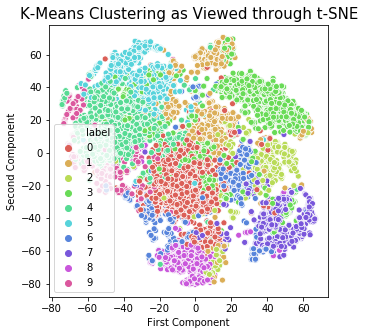

In [37]:
#Show us the plot of kmeans results using the same tsne hyperparameters as the first tsne we performed.
see_the_clusters('K-Means Clustering as Viewed through t-SNE',45,1000,200)

This is not an effective method of clustering according to our plot. 
### Scaling of data (3.d)
Now its possible that part of the issue comes from the fact that our data has been scaled, both at the beginning of the project, and once again in our function. However yes, the data has been scaled.
### How robust is your clustering? (How sensative it is?) (3.e)
The clustering is very inaccurate and not very robust. There is too much overlap to feel confident in this approach. ANd PCA combined with t-SNE seems to be more more effective.
## Performing hierarchical clustering (4)
Here is the last form of clustering that we're going to practice.  In order to do this, lets begin by getting ready to plot dendrograms. 

In [29]:
#import necessary modules
from scipy.cluster.hierarchy import dendrogram, linkage

### Plotting our first dendrogram (4.a)
We are going to plot our first dendrogram using the complete linkage method. This tends to be the most common method used.

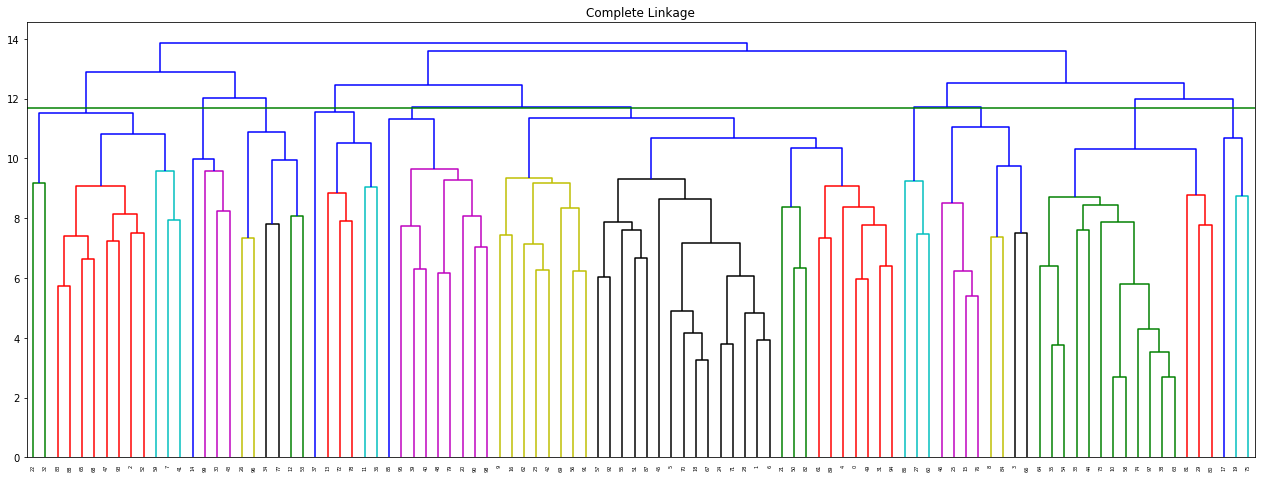

In [30]:
#Only use 100 observations and shuffle them
X_shuffled = shuffle(X,random_state=100)
x_dendro = X_shuffled[:100]
#link using the complete method
Z = linkage(x_dendro, 'complete')
#create plot and plot the dendrogram
plt.figure(figsize=(22, 8))
dendro = dendrogram(Z)
plt.title('Complete Linkage')
#plot where we can achieve the 10 groups
plt.hlines(11.7,0,10000,colors='g')

That is a very interesting looking plot! What does it mean though?
### How many clusters seem reasonable based off your graph? (4.b)

Although if using the colors it may seem that there are 20+ clusters, we can use a horizontal line to determine where we want to look in order to get the right number of clusters. At 11.7 (see the green line) we get 10 clusters, and we can use that when clustering data in the future. 

### How does our dendrogram change with different linkage methods? (4.c)

How do the different linkage methods affect this level? We're going to use each of the five mentioned in class and see what they do compared to the plot above (Complete):

>1. Complete - Use the maximum distance between points in clusters
>2. Ward - Merge the two clusters which minimize the total within-cluster variance after merging
>3. Average - Use the average distance between points in clusters
>4. Single (no sklearn) - Use the minimum distance between points in clusters
>5. Centroid (no sklearn) - Use the distance between the mean vector of each cluster

>-Tyler Folkman

We also will keep a red line at the same height (11.7) in every plot, but also see where we need to place a line to cluster the data into 10 groups (green line).

Let's look at the Ward Linkage method first:

In [31]:
#create a function that will allow us to quickly test the linkage type and use lines to compare
def plot_dendo(method,plot_title,height,height2):
    #shuffle
    X_shuffled = shuffle(X,random_state=100)
    Z = linkage(X_shuffled[0:100], method)
    #create figure
    plt.figure(figsize=(22, 8))
    #plot the dendro
    dendro = dendrogram(Z)
    #plot our lines and place a title
    plt.hlines(height,0,1000,colors='r')
    plt.hlines(height2,0,1000,colors='g')
    plt.title(plot_title,)

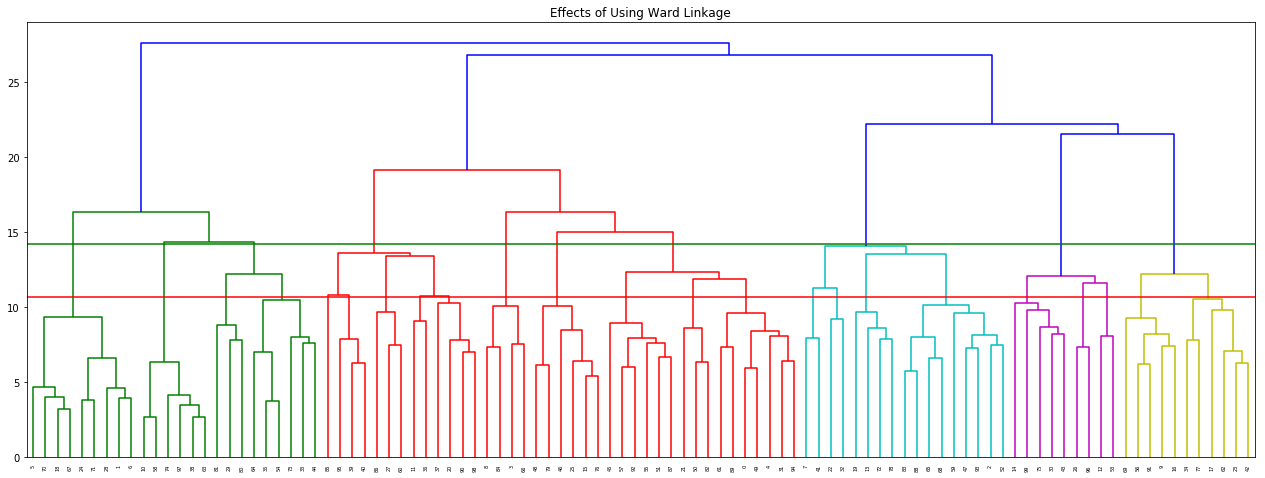

In [32]:
#test the ward linkage method and place our base line and 10 cluster line
plot_dendo('ward','Effects of Using Ward Linkage',10.7,14.2)

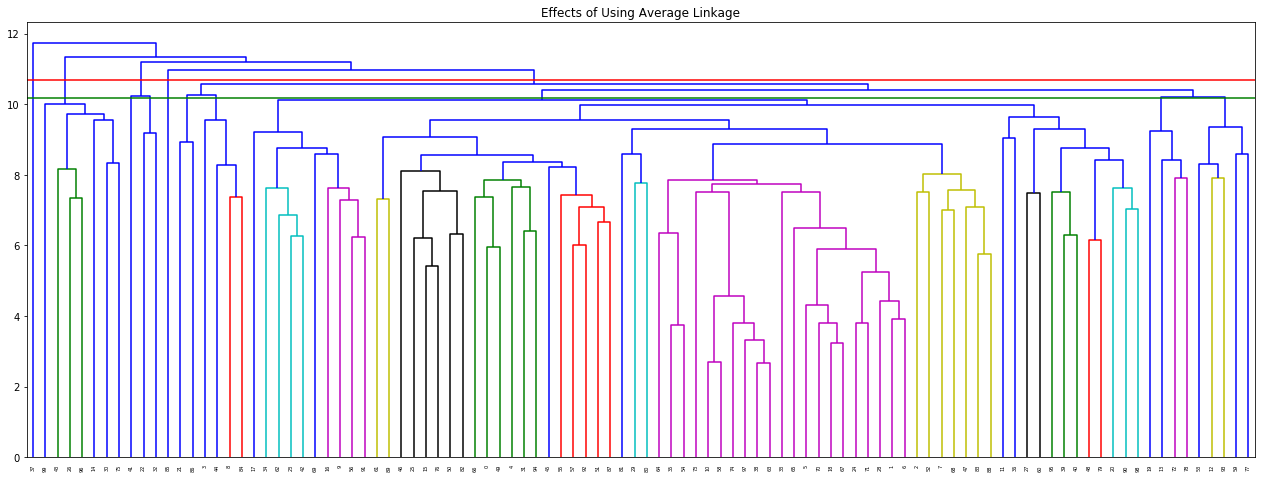

In [33]:
#test the average linkage method and place our base line and 10 cluster line
plot_dendo('average','Effects of Using Average Linkage',10.7,10.18)

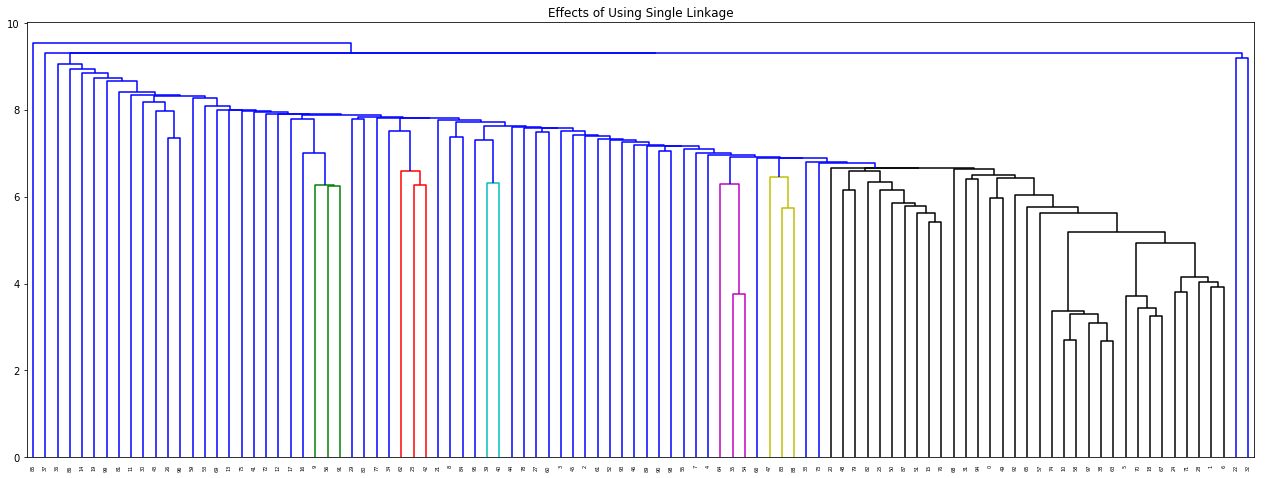

In [34]:
#test the single linkage method and place our base line and 10 cluster line
plot_dendo('single','Effects of Using Single Linkage',10.7,10.18)

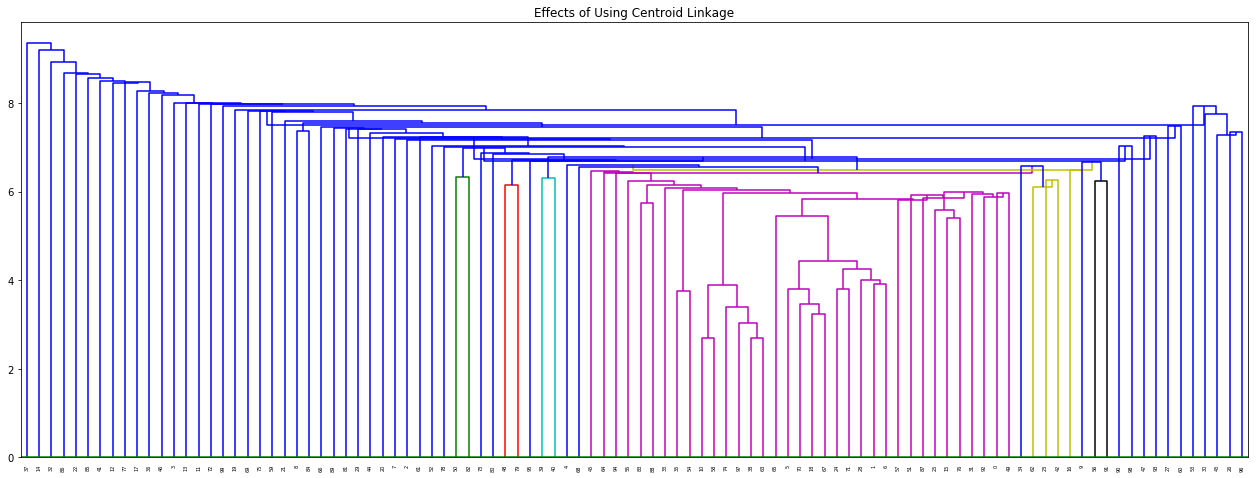

In [35]:
#test the centroid linkage method and place our base line and 10 cluster line
plot_dendo('centroid','Effects of Using Centroid Linkage',10.7,0)

Its pretty clear that the last two, both single and centroid, are not effective for clustering our data. Average is not great. However both Ward and Complete are very effective and should be considered in the future. In other words, the differences are significant, and each needs to be considered for different datasets. 

We now have used PCA, t-SNE, K-Means Clustering, and Heirarchical Clustering. These are incredible methods for machine learning and I'm very grateful for the opportunity to have learned to use these.

#### Sources
I would like to thank the many sources from which I recieved help with my coding:
- https://matplotlib.org/users/image_tutorial.html
- https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
- https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_Image_Reconstruction_and_such.ip
- Tyler Folkman, Conner Leavitt, and Mitchell Pudil